In [247]:
import copy
# Jupyter Notebook for Training Q-learning Player in Quixo Game

import random
import numpy as np
from game import Game, Move, Player


    
class RandomPlayer(Player):
    def __init__(self) -> None:
        super().__init__()

    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:
        from_pos = (random.randint(0, 4), random.randint(0, 4))
        move = random.choice([Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT])
        return from_pos, move

class MyPlayer(Player):
    def __init__(self, learning_rate, discount_factor, exploration_prob) -> None:
        super().__init__()
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_prob = exploration_prob
        self.q_values = {}
        self.currentState = None
        self.currentAction = None
        self.currentListAction = None
        self.learning = True 

    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:
        
        
        if self.learning:
            
            self.mon_caca(None, game)
    
            if np.random.rand() < self.exploration_prob:
                valid_moves = self.get_valid_moves(game)
                action_values = self.q_values.get(self.currentState, {action: 0 for action in valid_moves})
                random_action = random.choice(list(action_values))
                
                self.currentAction = random_action
                self.currentListAction = action_values
                
                from_pos, move = self.decode_action(random_action)
                return from_pos, move
            else:
                valid_moves = self.get_valid_moves(game)
                action_values = self.q_values.get(self.currentState, {action: 0 for action in valid_moves})
                best_action = max(action_values, key=action_values.get)
                best_quality = action_values.get(best_action)
                foo = [key for key in action_values if action_values.get(key) == best_quality]
                best_action = random.choice(foo)
                
                self.currentAction = best_action
                self.currentListAction = action_values
                
                from_pos, move = self.decode_action(best_action)
                return from_pos, move
        if not self.learning:
            
            state = self.get_state_representation(game)
            valid_moves = self.get_valid_moves(game)
            action_values = self.q_values.get(state, {action: 0 for action in valid_moves})
            best_action = max(action_values, key=action_values.get)
            
            best_quality = action_values.get(best_action)
            foo = [key for key in action_values if action_values.get(key) == best_quality]
            best_action = random.choice(foo)
            
            
            from_pos, move = self.decode_action(best_action)
            return from_pos, move
        
        
    
    def mon_caca(self ,booli = None , game: 'Game' = None) -> None:
        if booli is None:
            if self.currentState is None:
                self.currentState = self.get_state_representation(game)
                return None
            else:
                truc = self.get_state_representation(game)
                self.update_q_values(self.currentState, self.currentAction, self.currentListAction, 0, truc )
                self.currentState = truc
            return None
        if booli:
            self.update_q_values(self.currentState, self.currentAction, self.currentListAction ,1 )
            self.currentState = None
            self.currentAction = None
            self.currentListAction = None
            return None
        else:
            self.update_q_values(self.currentState, self.currentAction, self.currentListAction ,-1 )
            self.currentState = None
            self.currentAction = None
            self.currentListAction = None
            return None

    def get_state_representation(self, game: 'Game') -> str:
        return str(game.get_board().flatten().tolist() + [game.get_current_player()])

    def encode_action(self, from_pos: tuple[int, int], move: Move) -> str:
        return f"{from_pos[0]},{from_pos[1]},{move.value}"

    def decode_action(self, action: str) -> tuple[tuple[int, int], Move]:
        parts = action.split(',')
        return (int(parts[0]), int(parts[1])), Move(int(parts[2]))
    
    
    def get_valid_moves(self, game: 'Game') -> list[str]:
        valid_moves = []
        for x in range(5):
            for y in range(5):
                for move in [Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT]:
                    if game._board[x, y] == -1 or (x == 0 and move == Move.TOP) or (x == 4 and move == Move.BOTTOM) or \
                       (y == 0 and move == Move.LEFT) or (y == 4 and move == Move.RIGHT):
                        valid_moves.append(self.encode_action((x, y), move))
        return valid_moves
    
    
    

    def get_valid_moves2(self, game: 'Game') -> list[str]:
        valid_moves = []
        for x in range(5):
            for y in range(5):
                if self.__take((x, y), game.get_current_player(), game.get_board()):
                    for move in [Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT]:
                        if self.__slide((x, y), move, game.get_board()):
                            valid_moves.append(self.encode_action((x, y), move))
        return valid_moves

    def update_q_values(self, state: str, bestaction: str, actionlist, reward: int, next_state: str = None ) -> None:
        if state not in self.q_values:
            self.q_values[state] = actionlist
        
        current_q_value = self.q_values.get(state, {}).get(bestaction, 0)
        if next_state is not None:
            max_next_q_value = max(self.q_values.get(next_state, {}).values(), default=0)
        else:
            max_next_q_value = 0
        new_q_value = (1 - self.learning_rate) * current_q_value + self.learning_rate * (reward + self.discount_factor * max_next_q_value)
        
        
            
        self.q_values[state][bestaction] = new_q_value



    def __take(self, from_pos: tuple[int, int], player_id: int, board : np.ndarray) -> bool:
        '''Take piece'''
        # acceptable only if in border
        acceptable: bool = (
            # check if it is in the first row
            (from_pos[0] == 0 and from_pos[1] < 5)
            # check if it is in the last row
            or (from_pos[0] == 4 and from_pos[1] < 5)
            # check if it is in the first column
            or (from_pos[1] == 0 and from_pos[0] < 5)
            # check if it is in the last column
            or (from_pos[1] == 4 and from_pos[0] < 5)
            # and check if the piece can be moved by the current player
        ) and (board[from_pos] < 0 or board[from_pos] == player_id)
        if acceptable:
            board[from_pos] = player_id
        return acceptable

    def __slide(self, from_pos: tuple[int, int], slide: Move, board : np.ndarray) -> bool:
        '''Slide the other pieces'''
        # define the corners
        SIDES = [(0, 0), (0, 4), (4, 0), (4, 4)]
        # if the piece position is not in a corner
        if from_pos not in SIDES:
            # if it is at the TOP, it can be moved down, left or right
            acceptable_top: bool = from_pos[0] == 0 and (
                slide == Move.BOTTOM or slide == Move.LEFT or slide == Move.RIGHT
            )
            # if it is at the BOTTOM, it can be moved up, left or right
            acceptable_bottom: bool = from_pos[0] == 4 and (
                slide == Move.TOP or slide == Move.LEFT or slide == Move.RIGHT
            )
            # if it is on the LEFT, it can be moved up, down or right
            acceptable_left: bool = from_pos[1] == 0 and (
                slide == Move.BOTTOM or slide == Move.TOP or slide == Move.RIGHT
            )
            # if it is on the RIGHT, it can be moved up, down or left
            acceptable_right: bool = from_pos[1] == 4 and (
                slide == Move.BOTTOM or slide == Move.TOP or slide == Move.LEFT
            )
        # if the piece position is in a corner
        else:
            # if it is in the upper left corner, it can be moved to the right and down
            acceptable_top: bool = from_pos == (0, 0) and (
                slide == Move.BOTTOM or slide == Move.RIGHT)
            # if it is in the lower left corner, it can be moved to the right and up
            acceptable_left: bool = from_pos == (4, 0) and (
                slide == Move.TOP or slide == Move.RIGHT)
            # if it is in the upper right corner, it can be moved to the left and down
            acceptable_right: bool = from_pos == (0, 4) and (
                slide == Move.BOTTOM or slide == Move.LEFT)
            # if it is in the lower right corner, it can be moved to the left and up
            acceptable_bottom: bool = from_pos == (4, 4) and (
                slide == Move.TOP or slide == Move.LEFT)
        # check if the move is acceptable
        acceptable: bool = acceptable_top or acceptable_bottom or acceptable_left or acceptable_right
        # if it is
        if acceptable:
            # take the piece
            piece = board[from_pos]
            # if the player wants to slide it to the left
            if slide == Move.LEFT:
                # for each column starting from the column of the piece and moving to the left
                for i in range(from_pos[1], 0, -1):
                    # copy the value contained in the same row and the previous column
                    board[(from_pos[0], i)] = board[(
                        from_pos[0], i - 1)]
                # move the piece to the left
                board[(from_pos[0], 0)] = piece
            # if the player wants to slide it to the right
            elif slide == Move.RIGHT:
                # for each column starting from the column of the piece and moving to the right
                for i in range(from_pos[1], board.shape[1] - 1, 1):
                    # copy the value contained in the same row and the following column
                    board[(from_pos[0], i)] = board[(
                        from_pos[0], i + 1)]
                # move the piece to the right
                board[(from_pos[0], board.shape[1] - 1)] = piece
            # if the player wants to slide it upward
            elif slide == Move.TOP:
                # for each row starting from the row of the piece and going upward
                for i in range(from_pos[0], 0, -1):
                    # copy the value contained in the same column and the previous row
                    board[(i, from_pos[1])] = board[(
                        i - 1, from_pos[1])]
                # move the piece up
                board[(0, from_pos[1])] = piece
            # if the player wants to slide it downward
            elif slide == Move.BOTTOM:
                # for each row starting from the row of the piece and going downward
                for i in range(from_pos[0], board.shape[0] - 1, 1):
                    # copy the value contained in the same column and the following row
                    board[(i, from_pos[1])] = board[(
                        i + 1, from_pos[1])]
                # move the piece down
                board[(board.shape[0] - 1, from_pos[1])] = piece
        return acceptable

# Game with fixed q-learning parameters


In [270]:
# Training the Q-learning player
def train_q_learning_player(player, num_episodes=1000):
    player.q_values = {}
    for _ in range(num_episodes):
        print(_)
        a = Game()
        winnerre = a.play(player, RandomPlayer())
        if winnerre == 0:
            player.mon_caca(True)
        else:
            player.mon_caca(False)


#training:
my_player = MyPlayer(0.1,0.9,0.1)
my_player.learning = True
train_q_learning_player(my_player, num_episodes=10000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [282]:

#game
num_games = 100
wins = 0
my_player.learning = False


for _ in range(num_games):
    
    g = Game()
    
    winner = g.play(my_player, RandomPlayer())
    if winner == 0:
        wins += 1

winning_rate = wins / num_games
print(f"Winning Rate: {winning_rate * 100:.2f}%")

Winning Rate: 57.00%


# Game with search of optimal parameters

In [9]:
import matplotlib.pyplot as plt
import numpy as np


# Define ranges for hyperparameters
learning_rate_range = np.linspace(0.1, 0.9, 5)
discount_factor_range = np.linspace(0.1, 0.9, 5)
exploration_prob_range = np.linspace(0.1, 0.9, 5)

# Store results
results = []

# Perform grid search
for learning_rate in learning_rate_range:
    for discount_factor in discount_factor_range:
        for exploration_prob in exploration_prob_range:
            # Create and train Q-learning player
            q_learning_player = MyPlayer(learning_rate, discount_factor,exploration_prob)
            train_q_learning_player(q_learning_player, num_episodes=1000)

            # Evaluate winning rate
            num_games = 100
            wins = 0

            for _ in range(num_games):
                game = Game()
                winner = game.play(q_learning_player, RandomPlayer())
                if winner == 0:
                    wins += 1

            winning_rate = wins / num_games
            results.append({
                'learning_rate': learning_rate,
                'discount_factor': discount_factor,
                'exploration_prob': exploration_prob,
                'winning_rate': winning_rate
            })



learning_rates = [result['learning_rate'] for result in results]
discount_factors = [result['discount_factor'] for result in results]
exploration_probs = [result['exploration_prob'] for result in results]
winning_rates = [result['winning_rate'] for result in results]


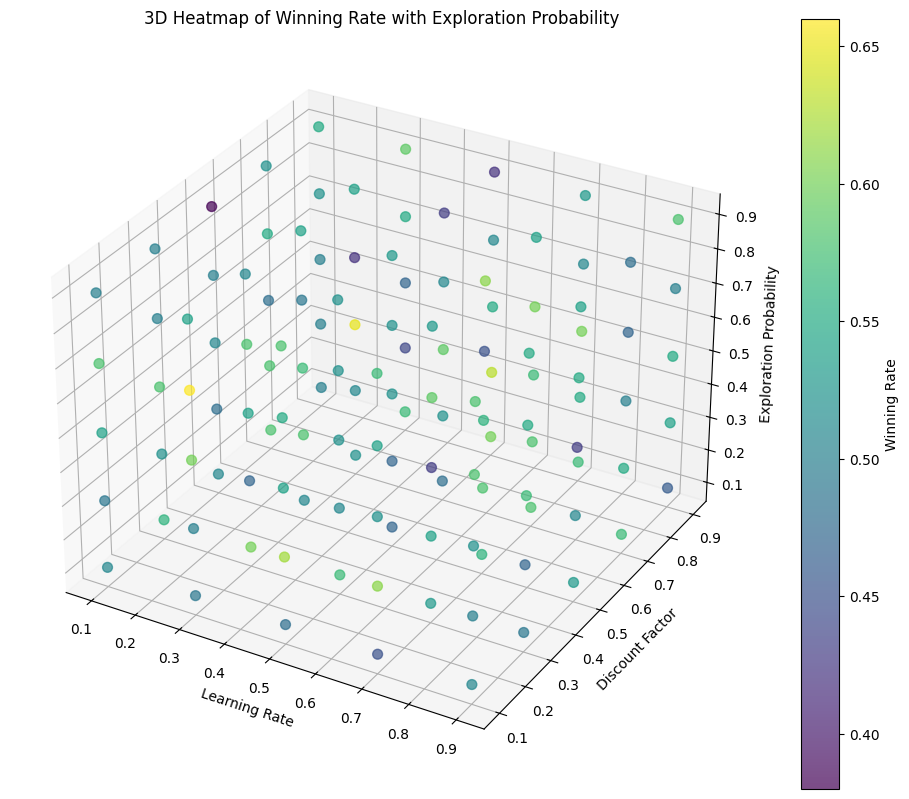

In [3]:
import seaborn as sns

# Convert results to a DataFrame for easier plotting
import pandas as pd
df_results = pd.DataFrame(results)

# 3D Heatmap
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Create a 3D scatter plot
scatter = ax.scatter(df_results['learning_rate'], df_results['discount_factor'], df_results['exploration_prob'],
                     c=df_results['winning_rate'], cmap='viridis', s=50, alpha=0.7)

# Set labels and title
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Discount Factor')
ax.set_zlabel('Exploration Probability')
ax.set_title('3D Heatmap of Winning Rate with Exploration Probability')

# Add a colorbar
cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Winning Rate')

plt.show()


C:\Users\Salma\AppData\Local\Temp\ipykernel_30100\2396195290.py:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[0, 0].plot(learning_rates, winning_rates, 'o-', markerfacecolor='blue', markersize=8, linestyle='')
C:\Users\Salma\AppData\Local\Temp\ipykernel_30100\2396195290.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[0, 1].plot(discount_factors, winning_rates, 'o-', markerfacecolor='orange', markersize=8, linestyle='')
C:\Users\Salma\AppData\Local\Temp\ipykernel_30100\2396195290.py:17: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[1, 0].plot(exploration_probs, winning_rates, 'o-', markerfacecolo

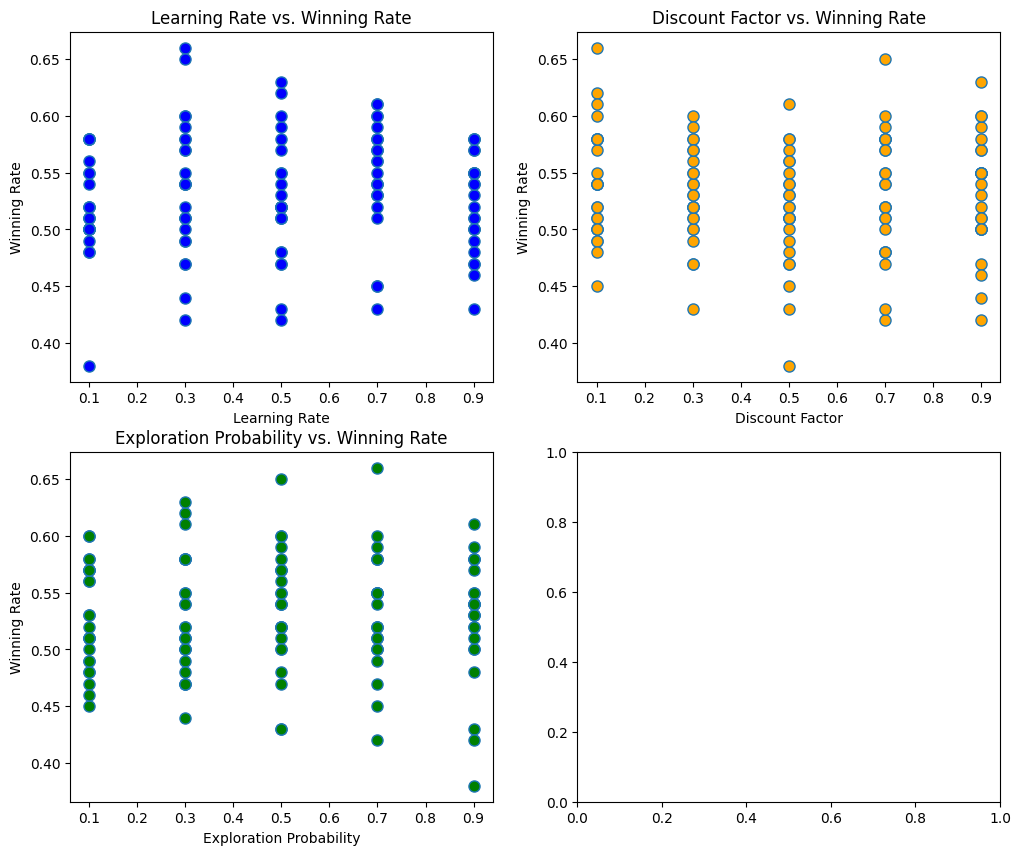

In [4]:
# Plot results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plotting learning_rate vs. winning_rate without lines
axes[0, 0].plot(learning_rates, winning_rates, 'o-', markerfacecolor='blue', markersize=8, linestyle='')
axes[0, 0].set_xlabel('Learning Rate')
axes[0, 0].set_ylabel('Winning Rate')
axes[0, 0].set_title('Learning Rate vs. Winning Rate')

# Plotting discount_factor vs. winning_rate without lines
axes[0, 1].plot(discount_factors, winning_rates, 'o-', markerfacecolor='orange', markersize=8, linestyle='')
axes[0, 1].set_xlabel('Discount Factor')
axes[0, 1].set_ylabel('Winning Rate')
axes[0, 1].set_title('Discount Factor vs. Winning Rate')

# Plotting exploration_prob vs. winning_rate without lines
axes[1, 0].plot(exploration_probs, winning_rates, 'o-', markerfacecolor='green', markersize=8, linestyle='')
axes[1, 0].set_xlabel('Exploration Probability')
axes[1, 0].set_ylabel('Winning Rate')
axes[1, 0].set_title('Exploration Probability vs. Winning Rate')

# Hide the lines connecting points
for ax in axes.flat:
    ax.legend().set_visible(False)

plt.show()


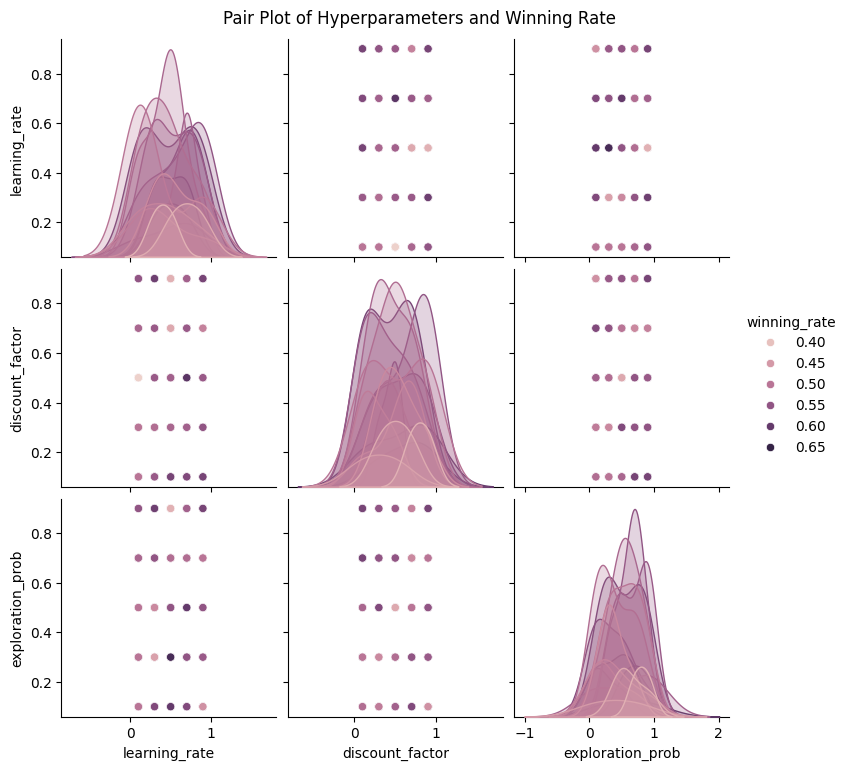

In [5]:
import seaborn as sns

# Convert results to a DataFrame for easier plotting
import pandas as pd
df_results = pd.DataFrame(results)

# Pair Plot
sns.pairplot(df_results, hue='winning_rate', markers='o')
plt.suptitle('Pair Plot of Hyperparameters and Winning Rate', y=1.02)
plt.show()


In [22]:
import numpy as np
from game import Move, Player

class MinimaxPlayer(Player):
    def __init__(self, max_depth=3):
        super().__init__()
        self.max_depth = max_depth

    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:
        _, move, from_pos = self.minimax_alpha_beta(game, self.max_depth, float('-inf'), float('inf'), True)
        return from_pos, move

    def minimax_alpha_beta(self, game, depth, alpha, beta, maximizing_player):
        if depth == 0 or game.check_winner() != -1:
            return self.evaluate_board(game), None, None

        legal_moves = game.get_possible_moves()

        if maximizing_player:
            max_eval = float('-inf')
            best_move = None
            best_from_pos = None
            for move in legal_moves:
                next_game = self.simulate_move(game, move)
                eval, _, from_pos = self.minimax_alpha_beta(next_game, depth - 1, alpha, beta, False)
                if eval > max_eval:
                    max_eval = eval
                    best_move = move
                    best_from_pos = from_pos
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break  # Beta cut-off
            return max_eval, best_move, best_from_pos
        else:
            min_eval = float('inf')
            best_move = None
            best_from_pos = None
            for move in legal_moves:
                next_game = self.simulate_move(game, move)
                eval, _, from_pos = self.minimax_alpha_beta(next_game, depth - 1, alpha, beta, True)
                if eval < min_eval:
                    min_eval 


In [24]:
import numpy as np

class GeneticPlayer(Player):
    def __init__(self, genes=None, mutation_rate=0.1):
        super().__init__()
        self.mutation_rate = mutation_rate
        self.genes = genes if genes is not None else self.initialize_genes()

    def initialize_genes(self):
        # Initialize genes randomly or with some heuristic
        # In this example, genes represent the probability distribution of moves
        return np.random.rand(5, 5, 4)

    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:
        # Choose a move based on the probability distribution in genes
        from_pos = self.select_position(game.get_board())
        move = self.select_move()
        return from_pos, move

    def select_position(self, board):
        # Select a position based on the probability distribution in genes
        probabilities = self.genes.flatten()
        probabilities /= probabilities.sum()
        index = np.random.choice(range(len(probabilities)), p=probabilities)
        return np.unravel_index(index, self.genes.shape[:-1])

    def select_move(self):
        # Select a move uniformly at random
        return random.choice([Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT])

    def crossover(self, partner):
        # Perform crossover to create a new player with combined genes
        new_genes = np.zeros_like(self.genes)
        mask = np.random.rand(*self.genes.shape) > 0.5
        new_genes[mask] = self.genes[mask]
        new_genes[~mask] = partner.genes[~mask]
        return GeneticPlayer(genes=new_genes)

    def mutate(self):
        # Mutate genes to introduce diversity
        mask = np.random.rand(*self.genes.shape) < self.mutation_rate
        self.genes[mask] = np.random.rand(*self.genes.shape)[mask]

def evolve_population(population, num_elites=2, mutation_rate=0.1):
    # Sort the population based on fitness
    population.sort(key=lambda player: evaluate_player(player), reverse=True)

    # Select the top players as elites
    elites = population[:num_elites]

    # Perform crossover and mutation to create the next generation
    new_population = elites.copy()
    while len(new_population) < len(population):
        parent1 = random.choice(elites)
        parent2 = random.choice(elites)
        child = parent1.crossover(parent2)
        child.mutate()
        new_population.append(child)

    return new_population

def evaluate_player(player, num_episodes=10):
    # Evaluate the player by playing against random opponents
    total_wins = 0
    for _ in range(num_episodes):
        random_opponent = RandomPlayer()
        game = Game()
        winner = game.play(player, random_opponent)
        if winner == 0:
            total_wins += 1

    return total_wins / num_episodes



In [25]:
if __name__ == '__main__':
    # Create an initial population of players
    population_size = 10
    initial_population = [GeneticPlayer() for _ in range(population_size)]

    # Evolution loop
    num_generations = 10
    for generation in range(num_generations):
        # Evaluate the fitness of each player in the population
        fitness_scores = [evaluate_player(player) for player in initial_population]

        # Print the average fitness of the generation
        avg_fitness = sum(fitness_scores) / len(fitness_scores)
        print(f"Generation {generation + 1}, Average Fitness: {avg_fitness}")

        # Evolve the population
        initial_population = evolve_population(initial_population)

    # Play the final evolved player against a RandomPlayer
    final_player = max(initial_population, key=lambda player: evaluate_player(player))
    random_opponent = RandomPlayer()

    g = Game()
    g.print()
    winner = g.play(final_player, random_opponent)
    g.print()
    print(f"Winner: Player {winner}")


ValueError: index 30 is out of bounds for array with size 25